|Nomenclature||
|------------|-|
|$\mathbf{x}$| point in the spatial domain|
|$t$| time |
|$p = p(\mathbf{x},t)$| pressure field |
|$\mathbf{u} = \mathbf{u}(\mathbf{x},t)$| velocity vector field |
|$T = T(\mathbf{x},t)$| temperature field |
|$\phi$ | solid volume fraction |
|$()_t = \frac{\partial}{\partial t}()$| time derivative |
|$T_r$| central temperature of the regularization |
|$r$| smoothing parameter of the regularization |
|$\mu$| constant dynamic viscosity of the fluid|
|$\mathbf{f}_B(T)$| temperature-dependent buoyancy force|
|$\mathrm{Pr}$ | Prandtl number|
|$\mathrm{Ra}$ | Rayleigh number|
|$\mathrm{Ste}$| Stefan number|
|$\Omega$| spatial domain |
|$\mathbf{w} = \begin{pmatrix} p \\ \mathbf{u} \\ T \end{pmatrix}$| system solution|
|$\mathbf{W}$| mixed finite element function space |
|$\boldsymbol{\psi} = \begin{pmatrix} \psi_p \\ \boldsymbol{\psi}_u \\ \psi_T \end{pmatrix} $| mixed finite element basis functions|
|$\gamma$| penalty method stabilization parameter|
|$T_h$| hot boundary temperature |
|$T_c$| cold boundary temperature |
|$\Delta t$| time step size |
|$\Omega_h$| discrete spatial domain, i.e. the mesh |
|$M$| goal functional |
|$\epsilon_M$| error tolerance for goal-oriented AMR |

## Governing equations

To model convection-coupled melting, we employ the system composed of the unsteady incompressible Navier-Stokes-Boussinesq equations and a enthalpy convection-diffusion equation, scaled for unit Reynolds Number as explained in [5], as

$$\begin{aligned}  \nabla \cdot \mathbf{u} &= 0  \\
    \mathbf{u}_t + \left( \mathbf{u}\cdot\nabla\right)\mathbf{u} + \nabla p - 2\nabla \cdot \left(\mu(\phi)\mathbf{D}(\mathbf{u})\right) + \mathbf{f}_B(T) &=0  \\ 
    T_t + \mathbf{u}\cdot\nabla T - \frac{1}{\mathrm{Pr}}\Delta T - \frac{1}{\mathrm{Ste}}\phi_t &=0 \end{aligned}$$

where  $\mathbf{D}(\mathbf{u}) = \mathrm{sym}(\mathbf{u}) = \frac{1}{2}\left(\nabla \mathbf{u} +  \left( \nabla \mathbf{u} \right)^{\mathrm{T}} \right)$ is the Newtonian fluid's rate of strain tensor and the regularized semi-phase-field (representing the solid volume fraction) is 

$$\begin{aligned} \phi(T) = \frac{1}{2}\left(1 + \tanh{\frac{T_r - T}{r}} \right) \end{aligned}$$

## Imports

In [1]:
import numpy as np
import pyvista
from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, assemble_scalar,
                         form, locate_dofs_geometrical, locate_dofs_topological, Expression )
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.plot import create_vtk_mesh

from dolfinx import mesh, fem, log

import dolfinx.nls.petsc

from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner)

from ufl import (FacetNormal, FiniteElement, Identity,TestFunction, TrialFunction, VectorElement,
div, dot, dx, inner, lhs, nabla_grad, rhs, sym, derivative, tanh)

import ufl


## Initial mesh

Define a coarse mesh on the unit square and refine it near the hot wall where there will be an initial layer of melt.

In [2]:
N=100

domain = mesh.create_unit_square(MPI.COMM_WORLD,N, N,cell_type=mesh.CellType.triangle)

#Left hand side wall
def HotWall(x):
    return np.logical_and(np.logical_and(np.isclose(x[1], 1) , x[0]>0.2), x[0]<0.8)

initial_hot_wall_refinement_cycles = 0

for cycle in range(initial_hot_wall_refinement_cycles):

    #Facets on the hot wall
    hot_wall = mesh.locate_entities_boundary(domain,domain.topology.dim-1,  HotWall) 

    domain = mesh.refine(domain, hot_wall, redistribute=False)

Visualize the mesh


cannot import name 'vtk' from 'trame.widgets' (/Users/jorgenin/Documents/Python/Research/CustomFEMSIM/FEM/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(



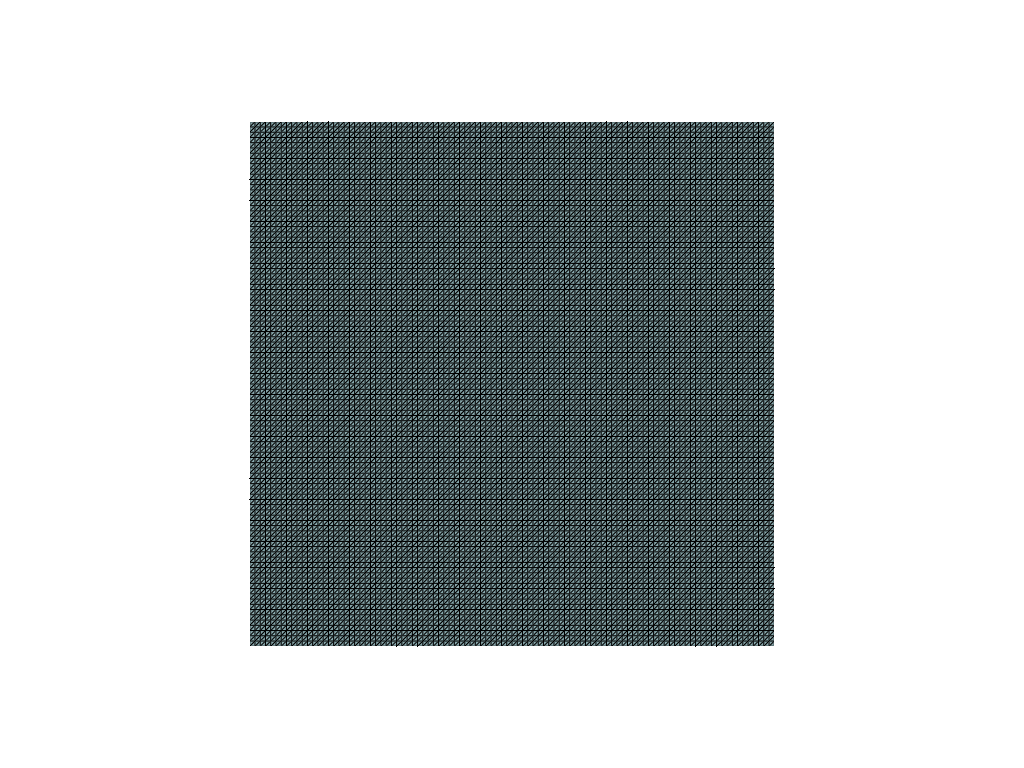

In [3]:
plotter = pyvista.Plotter(notebook="true")


vtkdata = create_vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()
plotter.close()

## Mixed finite element function space, test functions, and solution functions


We're changing this here to make it just a P1 space to simplify the stefan problem. We will expand to convection if need be.

In [4]:
P2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1)
P1s = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 2)
#TH = ufl.MixedElement([P1, P2, P1])
TH = P1s
#P2 is a vector element to account for velocity
#P1 is a scalar element to account for pressure and temperature
W = FunctionSpace(domain, TH)

Make the system solution function $\mathbf{w} \in \mathbf{W}$ and obtain references to its components $p$, $\mathbf{u}$, and $T$.

In [5]:
w = Function(W)
T = w #Technically w is just a single temperature problem

Set constant Prandtl, Rayleigh, and Stefan numbers for the convection-coupled melting benchmark in [5] and [6]. For each we define a Constant for use in the variational form so that FEniCS can more efficiently compile the finite element code.

In [6]:
thermal_conducitivty= 27
density = 7000
DynamicViscosity = 7e-3
specific_heat = 712

thermal_diffusivity = thermal_conducitivty/(density*specific_heat)

KinematicViscosity = DynamicViscosity/density

prandtl_number =KinematicViscosity/thermal_diffusivity

Pr = Constant(domain,PETSc.ScalarType(prandtl_number))

V_set = .0001
H = 0.01

Reynolds_Number = V_set*H/KinematicViscosity

Re = Constant(domain,PETSc.ScalarType(Reynolds_Number))

#rayleigh_number = 3.27e5

#Ra = Constant(domain,PETSc.ScalarType(rayleigh_number))

stefan_number = 800/2.76e5*33

Ste = Constant(domain,PETSc.ScalarType(stefan_number))

Steff2 =  800/7.34e6*33


Ste2 = Constant(domain,PETSc.ScalarType(Steff2))

Define the idealized linear Boussinesq buoyancy, scaled according to [5]

$$\begin{aligned} \mathbf{f}_B(T) = \frac{\mathrm{Ra}}{\mathrm{Pr}} T\begin{pmatrix} 0 \\ -1 \end{pmatrix}. \end{aligned}$$

In [7]:
#f_B = Ra/Pr*T*Constant(domain,PETSc.ScalarType([0., -1.]))

Set the regularized semi-phase-field with a central temperature $T_r$ and smoothing parameter $r$.

In [8]:
regularization_central_temperature = 0.1

T_r = Constant(domain,PETSc.ScalarType(regularization_central_temperature))

T_r2 = Constant(domain,PETSc.ScalarType(regularization_central_temperature+.2))


regularization_smoothing_parameter = 0.05

r = Constant(domain,PETSc.ScalarType(regularization_smoothing_parameter))

def phi(T):
    return 0.5*(1. + tanh((T_r - T)/r))

def phi_s(T):
    return 1./Ste-1./(2*Ste)*(1. + tanh((T_r - T)/r))


def phi2(T): 
    return 0.5*(1. + tanh((T_r2 - T)/r))
    
def phi_s2(T):
    return 1./Ste2-1./(2*Ste2)*(1. + tanh((T_r - T)/r))


Set the phase-dependent dynamic viscosity

In [9]:
liquid_dynamic_viscosity = 1.

mu_L = Constant(domain,PETSc.ScalarType(liquid_dynamic_viscosity))


solid_dynamic_viscosity = 1.e8

mu_S = Constant(domain,PETSc.ScalarType(solid_dynamic_viscosity))

def mu(phi):
    
     return mu_L + (mu_S - mu_L)*phi

Furthermore the benchmark problem involves hot and cold walls with constant temperatures $T_h$ and $T_c$, respectively.

In [10]:
hot_wall_temperature = 1.

T_h = Constant(domain,PETSc.ScalarType(hot_wall_temperature))

cold_wall_temperature = -1

T_c = Constant(domain,PETSc.ScalarType(cold_wall_temperature))

## Time discretization

To solve the initial value problem, we will prescribe the initial values, and then take discrete steps forward in time which solve the governing equations.

We set the initial values such that a small layer of melt already exists touching the hot wall.

\begin{align*} p^0 &= 0 \\ \mathbf{u}^0 &= \mathbf{0} \\ T^0 &= \begin{cases} T_h, && x_0 < x_{m,0} \\ T_c, && \mathrm{otherwise} \end{cases} \end{align*}

Interpolate these values to create the initial solution function

In [11]:
initial_melt_thickness = 0
x_m = Constant(domain,PETSc.ScalarType(initial_melt_thickness))

def InitialTempExp(x):
    
    return (hot_wall_temperature-cold_wall_temperature)*(x[1]>1-initial_melt_thickness)*np.exp(-1/2*((x[0]-.5)/.06)**2)/(.06*np.sqrt(2*np.pi))+cold_wall_temperature


#w_n = Function(W)
#p_n, u_n, T_n = w_n.split()
T_n = Function(W)
T_n.interpolate(InitialTempExp)

  viridis = plt.cm.get_cmap("viridis", 25)


cannot import name 'vtk' from 'trame.widgets' (/Users/jorgenin/Documents/Python/Research/CustomFEMSIM/FEM/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(



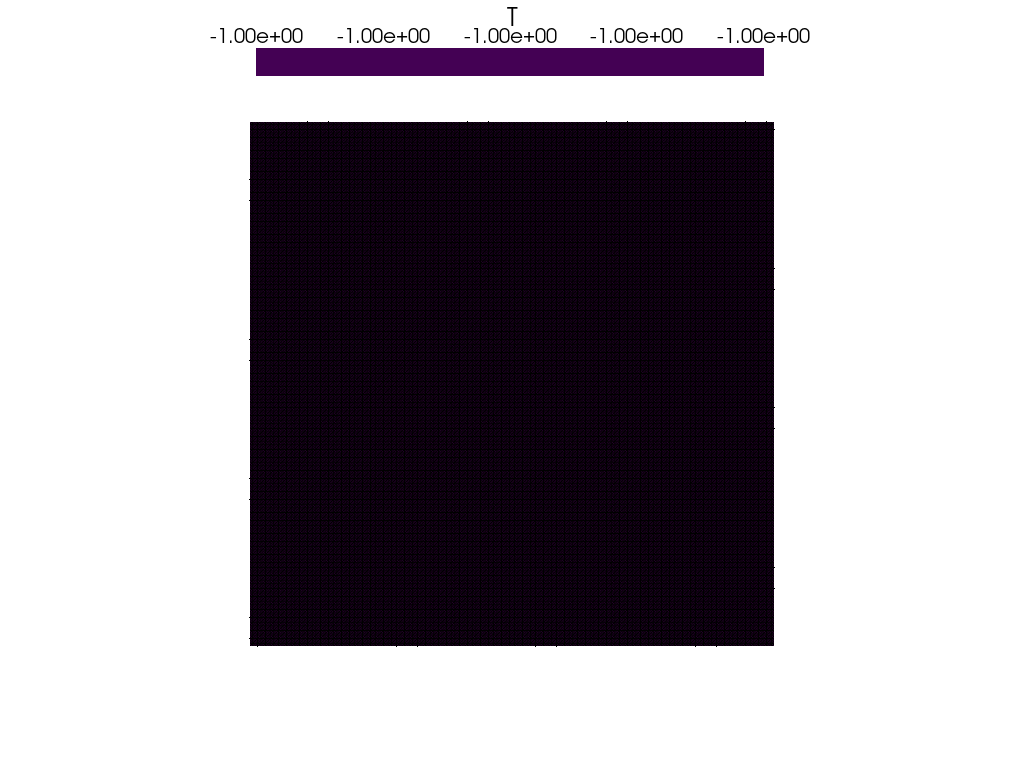

In [12]:
import matplotlib.pyplot as plt
#dummy function space for plotting
W_dummy = FunctionSpace(domain, ("Lagrange", 2))
cells, types, x = create_vtk_mesh(W_dummy)

grid = pyvista.UnstructuredGrid(cells, types, x)

grid.point_data["T"] = T_n.x.array

plotter = pyvista.Plotter(notebook="true")

viridis = plt.cm.get_cmap("viridis", 25)

sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.25, position_y=.9, width=0.5, height=0.1)

warped = grid.warp_by_scalar("T", factor=0)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[-1, max( T_n.x.array)])

actor = plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()
plotter.close()

For the time derivative terms $\mathbf{u}_t$, $T_t$, and $\phi_t$, we apply the first-order implicit Euler finite difference time discretization, i.e.

\begin{align*} \mathbf{u}_t = \frac{\mathbf{u}^{n+1} - \mathbf{u}^n}{\Delta t} \\ T_t = \frac{T^{n+1} - T^n}{\Delta t} \\ \phi_t = \frac{\phi^{n+1} - \phi^n}{\Delta t} \end{align*}

Note
For our implementation, we will use the shorthand $\mathbf{w_n} = \mathbf{w}^{n+1}$
Choose a time step size and set the time derivative terms.

In [13]:


#u_n is the previous solution essentially
Timestep_size = 1/50

Delta_t = Constant(domain,PETSc.ScalarType(Timestep_size))


T_t = (T - T_n)/Delta_t

phi_t = (phi(T) - phi(T_n))/Delta_t
phi_s_t = (phi_s(T) - phi_s(T_n))/Delta_t
phi_s_t2 = (phi_s2(T) - phi_s2(T_n))/Delta_t

cs = 712
cl = 800
C = 1 + (cs/cl-1)/2*(phi(T))#non dimensional specific heat
C_t = (C - (1 + (cs/cl-1)/2*(phi(T_n))))/Delta_t#non dimensional specific heat


kl =27
ks = 29

Kfun = lambda T: 1 + (ks/kl-1)/2*(phi(T))

K = Kfun(T)

K_t = (Kfun(T)-Kfun(T_n))/Delta_t


## Nonlinear variational form


We can write the nonlinear system of equations as

$$\begin{aligned} \mathbf{F}(\mathbf{w}) = \mathbf{0} \end{aligned}$$


To obtain the finite element weak form, we follow the standard Ritz-Galerkin method extended for mixed finite elements [1]. Therefore, we multiply the system from the left by test functions $\boldsymbol{\psi}$ from the mixed finite element function space $\mathbf{W}$ and integrate over the spatial domain $\Omega$. This gives us the variational problem: Find 
$\mathbf{w} \in \mathbf{W}$ such that

$$\begin{aligned} \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = \int_\Omega \boldsymbol{\psi}^\mathrm{T} \mathbf{F}(\mathbf{w}) d\mathbf{x} = 0 \quad \forall \boldsymbol{\psi} \in \mathbf{W} \end{aligned}$$


Integrating $\mathcal{F}$ by parts yields

$$\begin{aligned} \mathcal{F}(\boldsymbol{\psi};\mathbf{w}) = -(\psi_p,\nabla\cdot\mathbf{u}) \\ + (\boldsymbol{\psi}_u, \mathbf{u}_t + \nabla\mathbf{u}\cdot\mathbf{u} + \mathbf{f}_B(T)) (\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathbf{D}(\boldsymbol{\psi}_u),\mathbf{D}(\mathbf{u})) \\ + (\psi_T,T_t - \frac{1}{Ste}\phi_t) + (\nabla \psi_T, \frac{1}{\mathrm{Pr}}\nabla T - T\mathbf{u}) \end{aligned}$$


Note
We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.

By default FEniCS will numerically integrate with an exact quadrature rule. For this particular problem, this yields a large enough number of quadrature points that FEniCS throws a warning. Let's choose a lower degree quadrature, which will greatly speed up the finite element matrix assembly.

In [14]:
#dxs = ufl.dx(metadata={'quadrature_degree': 8})

Define the nonlinear variational form $\mathcal{F}$.

In [15]:
psi_T = ufl.TestFunction(W)
#mass = -psi_p*div(u)

#momentum = dot(psi_u, u_t + dot(grad(u), u) + f_B) - div(psi_u)*p \
#    + 2.*mu(phi(T))*inner(sym(grad(psi_u)), sym(grad(u))) 
#Non dimensional conductivity
 #Stefan number non dimensional
enthalpy = dot(psi_T,dot(C,T_t)+dot(C_t,T)) + dot(psi_T, dot(C,phi_s_t)+dot(C_t,phi_s(T))) +dot(psi_T, dot(C,phi_s_t2)+dot(C_t,phi_s2(T)))+ dot(grad(psi_T),K/(Re*Pr)*grad(T))
#momentum + enthalpy  
F = (enthalpy)*dx

We add a penalty method stabilization term $-\gamma(\psi_p,p)$, setting the stabilization parameter $\gamma = 10^{-7}$ as done in [5].

In [16]:
#penalty_stabilization_parameter = 1.e-7

#gamma = Constant(domain,PETSc.ScalarType(penalty_stabilization_parameter))

#F += -psi_p*gamma*p*dxs

## Linearization


Notice that $\mathcal{F}$ is a nonlinear variational form. FEniCS will solve the nonlinear problem using Newton's method. This requires computing the Jacobian (formally the Gâteaux derivative) of the nonlinear variational form, yielding a a sequence of linearized problems whose solutions may converge to approximate the nonlinear solution.

We could manually define the Jacobian; but thankfully FEniCS can do this for us.

Note
When solving linear variational problems in FEniCS, one defines the linear variational form using fenics.TrialFunction instead of fenics.Function (while both approaches will need fenics.TestFunction). When solving nonlinear variational problems with FEniCS, we only need fenics.TrialFunction to define the linearized problem, since it is the linearized problem which will be assembled into a linear system and solved.

### Boundary conditions

We need boundary conditions before we can define a nonlinear variational problem (i.e. in this case a boundary value problem).

We physically consider no slip velocity boundary conditions for all boundaries. These manifest as homogeneous Dirichlet boundary conditions. For the temperature boundary conditions, we consider a constant hot temperature on the left wall, a constant cold temperature on the right wall, and adiabatic (i.e. zero heat transfer) conditions on the top and bottom walls. Because the problem's geometry is simple, we can identify the boundaries with the following piece-wise function.

\begin{align*} T(\mathbf{x}) &= \begin{cases} T_h , && x_0 = 0 \\ T_c , && x_0 = 1 \end{cases} \end{align*}

In [17]:
def HotWall1(x):
    return np.logical_and(np.logical_and(np.isclose(x[1], 1) , x[0]>0.2), x[0]<0.8)

def ColdWall1(x):
     return np.isclose(x[1], 0)

def AdiabaticWall(x):
     return np.logical_or(np.isclose(x[0], 0),np.isclose(x[0], 1))


def walls(x):
    return  np.logical_or(np.logical_or(HotWall1(x),ColdWall1(x)),AdiabaticWall(x))

In [18]:
boundaries = [(1, HotWall1)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [19]:
#
g = lambda x: ufl.exp(-1/2*((x[0]-.5)/.005)**2)/(.005*np.sqrt(2*np.pi))*10000000
x = SpatialCoordinate(domain)
val = g(x)

domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

LaserOn = Constant(domain, PETSc.ScalarType(1))
#(V_set/H)**3*g(x)
F += -inner(inner(psi_T,(V_set/H)**3*val),LaserOn)*ds(1)

In [20]:
q = TrialFunction(W)
JF = derivative(F, w, q)

Define the boundary conditions on the appropriate subspaces.

In [21]:
#W_u,_ = W.sub(1).collapse()

#W_T,_ = W.sub(2).collapse()
#u_0 = fem.Function(W_u)
#u_0.x.array[:] = 0

hotwall = fem.locate_dofs_geometrical(W, HotWall1)
coldwall = locate_dofs_geometrical(W, ColdWall1)
#ZeroVelocity = locate_dofs_geometrical(W , walls)


boundary_conditions = []
    #dirichletbc(u_0, ZeroVelocity , W.sub(1)),
    #dirichletbc(PETSc.ScalarType(hot_wall_temperature), hotwall, W),
   #dirichletbc(PETSc.ScalarType(cold_wall_temperature), coldwall ,W)]


In [22]:
problem = fem.petsc.NonlinearProblem(F, w, [], JF)

### Goal-oriented adaptive mesh refinement (AMR)

We wish to solve the problem with adaptive mesh refinement (AMR). For this it helps to explain that we have already defined the discrete nonlinear variational problem using FEniCS: Find $\mathbf{w}_h \in \mathbf{W}_h \subset \mathbf{W}(\Omega)$ such that

\begin{align*} \mathcal{F}(\boldsymbol{\psi}_h;\mathbf{w}_h) = 0 \quad \forall \boldsymbol{\psi}_h \in \mathbf{W}_h \subset \mathbf{W} \end{align*}

Given this, goal-oriented AMR poses the problem: Find $\mathbf{W}_h \subset \mathbf{W}(\Omega)$ and $\mathbf{w}_h \in \mathbf{W}_h$ such that

$$\begin{aligned} \left| M(\mathbf{w}) - M(\mathbf{w}_h) \right| < \epsilon_M \end{aligned}$$
where $M$ is some goal functional of the solution which we integrate over the domain, and where $\epsilon_M$ is a prescribed tolerance. Note that since we do not know the exact solution $\mathbf{w}$, this method requires an error estimator. This is detailed in [2]. For our purposes, we only need to define $M$ and $\epsilon_M$.

We choose a goal analagous to the melting rate.

\begin{align*} M = \int_\Omega \phi_t \hspace{1mm} d\mathbf{x} \end{align*}

In [23]:
#M = phi_t*dxs

Let's set the tolerance somewhat arbitrarily. For real problems of scientific or engineering interest, one might have accuracy requirements which could help drive this decision.

In [24]:
epsilon_M = 4.e-5

In [25]:
solver = dolfinx.nls.petsc.NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 4e-8
solver.atol = 1e-9
solver.max_it = 1000
solver.report = True

We can modify the linear solver in each Newton iteration by accessing the underlying PETSc object.



In [26]:
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 1000
ksp.setFromOptions()

We are now ready to solve the non-linear problem. We assert that the solver has converged and print the number of iterations.

In [27]:
log.set_log_level(log.LogLevel.INFO)
#n, converged = solver.solve(w)
#print(f"Number of interations: {n:d}")

In [28]:
import pyvista
import matplotlib.pyplot as plt
t=0

phi_ex = lambda arr:  0.5* (1 + np.tanh(arr-regularization_central_temperature)/regularization_smoothing_parameter)
phi_ex2 = lambda arr:  0.5* (1 + np.tanh(arr-(regularization_central_temperature+.2))/regularization_smoothing_parameter)

grid = pyvista.UnstructuredGrid(*create_vtk_mesh(W))

plotter = pyvista.Plotter(notebook="true")
plotter.open_gif("W_time.gif")

grid.point_data["Solid Volume Fraction"] =phi_ex(w.x.array)+phi_ex2(w.x.array)
warped = grid.warp_by_scalar("Solid Volume Fraction", factor=0)

viridis = plt.cm.get_cmap("viridis", 25)
sargs = dict(title_font_size=25, label_font_size=20, fmt="%.2e", color="black",
             position_x=0.25, position_y=0.9, width=0.5, height=0.1)

renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            clim=[0, 2])

  viridis = plt.cm.get_cmap("viridis", 25)



In [29]:
plotter.view_xy()
num_steps =50
dt = Timestep_size
t=0
for i in range(num_steps):
    t += dt
    if(t > .5):
        LaserOn.value =0
    ## Update the right hand side reusing the initial vector
    #with b.localForm() as loc_b:
    #    loc_b.set(0)
    #fem.petsc.assemble_vector(b, linear_form)
    
    # Apply Dirichlet boundary condition to the vector
    #fem.petsc.apply_lifting(b, [bilinear_form], [[bc]])
    #b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    #fem.petsc.set_bc(b, [bc])

    # Solve linear problem
    solver.solve(w)
    w.x.scatter_forward()

    # Update solution at previous time step (u_n)
    T_n.x.array[:] = w.x.array

    # Write solution to file
    # Update plot
    

    warped = grid.warp_by_scalar("Solid Volume Fraction", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=True)
    plotter.update_scalars( phi_ex(w.x.array)+phi_ex2(w.x.array),render=True)
    plotter.render()
    plotter.write_frame()
plotter.close()


2023-08-18 22:23:31.300 (   1.135s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-08-18 22:23:32.191 (   2.026s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-08-18 22:23:32.372 (   2.207s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 8.56116 (tol = 1e-09) r (rel) = 1.23276(tol = 4e-08)
2023-08-18 22:23:32.565 (   2.400s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-08-18 22:23:32.756 (   2.591s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 3: r (abs) = 17.6961 (tol = 1e-09) r (rel) = 2.54813(tol = 4e-08)
2023-08-18 22:23:32.948 (   2.782s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-08-18 22:23:33.183 (   3.018s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 4: 

: 